### Abstract

Here we investigate how people adjust their behaviour to the underlying temporal structure of changes. For this purpose we have modified a standard reversal learning task to include exploratory (epistemic) choices, which participants can use to learn the correct choice on the current trial. Participants were separated in two groups, each group exposed to different experimental conditions characterised by a different temporal structure of reversals. The differences in experimental conditions is illustrated bellow.

To understand the interplay between beliefs about temporal structure and behaivour we have used an active inference agent based on hidden semi-Markov models, allowing us to model learning of temporal strucure, besides learning of choice outcome contingencies, and online inference of the hidden context.

We illustrate participants behaviour using two measures of performance, expected reward and trials until correct. 

Quanitfying the probability of exploratory choices at each trial relative to the moment of reversals we can identify distinct characteristic responses of behaviour in two experimental conditions. This results suggest that people are sensitive to the temporal structure of the reversals (they can learn it) and that they use this structure for infering most likely moments of reversals, as reflected in the statistics of exploratory choices.

In [1]:
# import packages and set environment
import sys
import os
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

from matplotlib import cm, colors

from stats import running_mean, performance

from scipy import io

%matplotlib inline
jtplot.style(theme='grade3', context='paper', fscale=1.6, grid=False)

In [2]:
# load experimental parameters
states_and_rewards = io.loadmat('main/states_and_rewards.mat')
Sirr = states_and_rewards['irregular']['S'][0, 0][:, 0] - 1
Oirr = states_and_rewards['irregular']['R'][0, 0]
Sreg = states_and_rewards['regular']['S'][0, 0][:, 0] - 1
Oreg = states_and_rewards['regular']['R'][0, 0]

In [3]:
# import data loader
from stats import load_data

# load behavioural data
outcomes_data, responses_data, mask_data, counts, correct_choices_data, conditions = load_data()

nsub, ns_reg, ns_irr = counts

pilot = conditions.experiment == 'pilot'
ns_pilot = sum(pilot)
ns_pilot_reg = sum( conditions.loc[pilot, 'condition'] == 'regular')
ns_pilot_irr = sum( conditions.loc[pilot, 'condition'] == 'irregular')
print(' Total number of subjects is {}, of which {} where asigned to regular condition and {} where tested during a pilot study (without exploration option). In the pilot study {} subjects where asigned to the regular condition.'.format(nsub, ns_reg, ns_pilot, ns_pilot_reg))

 Total number of subjects is 74, of which 41 where asigned to regular condition and 24 where tested during a pilot study (without exploration option). In the pilot study 14 subjects where asigned to the regular condition.


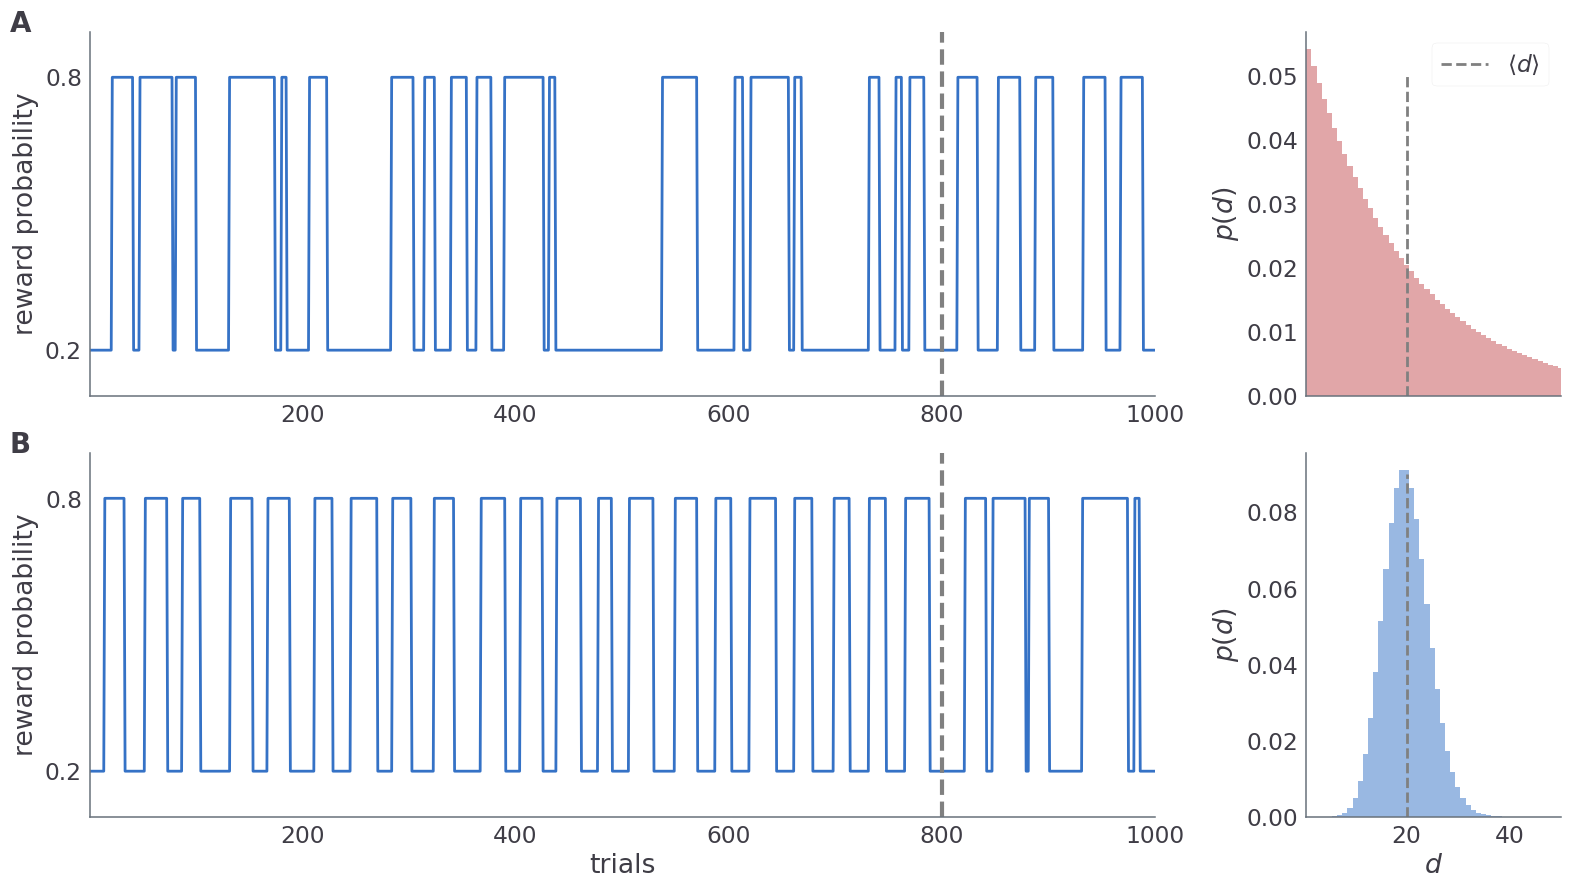

In [4]:
from scipy.special import loggamma

def softmax(x, dim):
    v = x - x.sum(dim, keepdims=True)
    return np.exp(v)/np.exp(v).sum(dim, keepdims=True)

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 9), sharex=True)
gs = axes[0, 0].get_gridspec()
# remove the underlying axes
for ax in axes[:, :-1].flatten():
    ax.remove()
axbig1 = fig.add_subplot(gs[0, :-1])
axbig2 = fig.add_subplot(gs[1, :-1])

trials = np.arange(1, len(Sirr) + 1)

axbig1.plot(trials, .6 * Sirr + .2, lw=2)
axbig1.vlines(800, .1, .9, lw=3, color='gray', linestyle='--')
axbig1.set_yticks([.2, .8])
axbig1.set_ylabel('reward probability')

axbig2.plot(trials, .6 * Sreg + .2, lw=2)
axbig2.vlines(800, .1, .9, lw=3, color='gray', linestyle='--')
axbig2.set_ylabel('reward probability')
axbig2.set_xlabel('trials')
axbig2.set_yticks([.2, .8])

axbig1.set_xlim([1, len(Sirr)])
axbig1.set_ylim([.1, .9])

axbig2.set_xlim([1, len(Sirr)])
axbig2.set_ylim([.1, .9])

mu = 19
color = ['r', 'b']
d = np.arange(1., 51.)
for i, nu in zip(range(3), [1., 10000.]):
    k = d - 1
    lbinom = loggamma(k + nu) - loggamma(d) - loggamma(nu)
    delta = mu / (mu + nu)
    p0 = softmax(lbinom + k * np.log(delta) + nu * np.log(1-delta), -1)
    axes[i, -1].bar(d, p0, alpha = .5, color=color[i], width=1)
    axes[i, -1].set_xlim([.5, 50])
    
axes[0, -1].vlines(20, 0, 0.05, color='gray', linestyle='--', label=r'$\langle d \rangle$', lw=2)
axes[1, -1].vlines(20, 0, 0.09, color='gray', linestyle='--', lw=2)
axes[0, -1].legend()

axes[0, -1].set_ylabel(r'$p(d)$')
axes[1, -1].set_ylabel(r'$p(d)$')
axes[1, -1].set_xlabel(r'$d$')

fig.align_labels()
fig.tight_layout()
sns.despine(fig)

axes = [axbig1, axbig2]
for i in range(2):
    axes[i].text(-.075, 1., string.ascii_uppercase[i], transform=axes[i].transAxes, size=20, weight='bold')

fig.savefig('Fig2.pdf', bbox_inches='tight', transparent=True, dpi=300)

In the regular condition, shown at the bottom of the figure, the participants were exposed to a regular (predictable) reversals for 800 trials and then to an irregular sequence of reversals for 200 trials (same reversal rate but les predictable moment of reversals). In the irregular condition, shown at the top, the participant were first exposed to irregular reversals (for 800 trials) and then to a 200 trial long sequence of regular reversals. Note that the sequences after the regime change correspond to the first 200 trials of the alternative condition.

In [5]:
# mark subjects which generated less than 20 exploratory responses
expl_subs = (responses_data == 2).sum(0) > 0
expl_sub_num = np.arange(nsub)[expl_subs]
nexpl_sub_num = np.arange(nsub)[~expl_subs]
print(len(nexpl_sub_num), len(expl_sub_num))

29 45


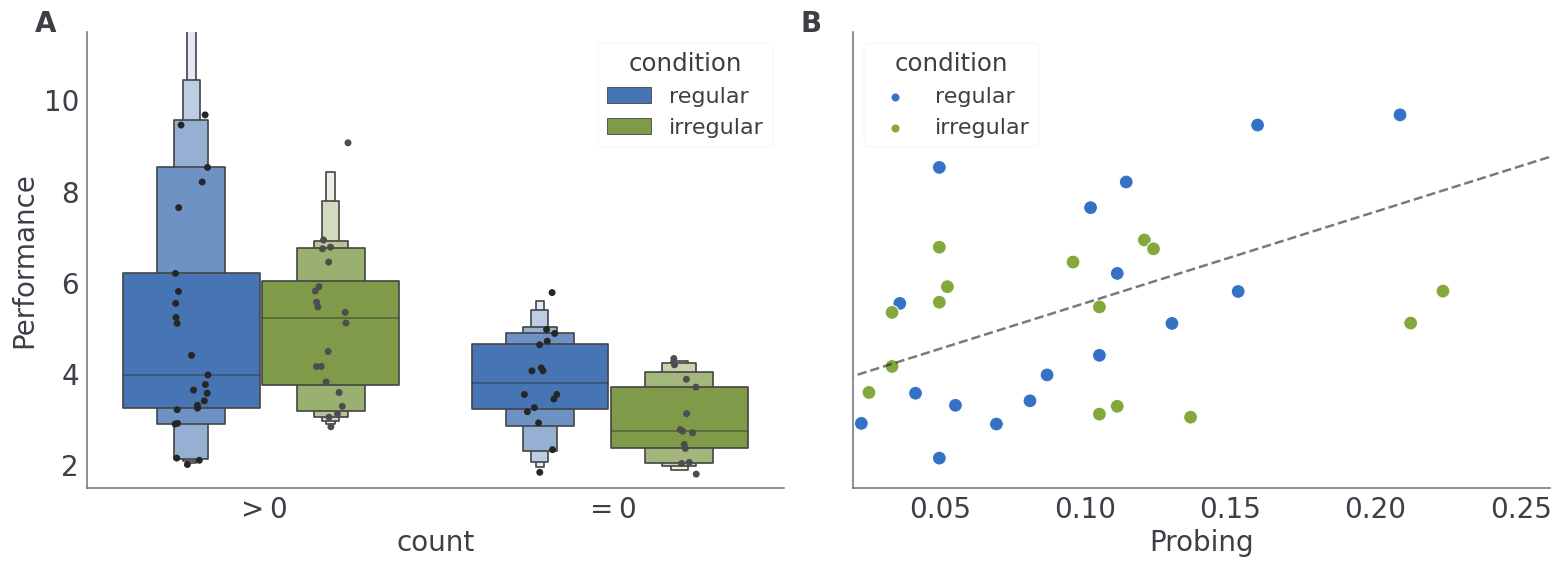

In [6]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=16)

cutoff = 400
perf = np.nanmean(correct_choices_data[cutoff:-200], -2)
df = pd.DataFrame({'performance': perf/(1-perf)})

df['exploration'] = np.nanmean(responses_data[cutoff:-200] == 2, -2)
df['probing'] = df['exploration'] / (1 - df['exploration'])

df['condition'] = conditions.condition
df['count'] = r'$=0$'
df.loc[expl_sub_num, 'count'] = r'$>0$'

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.boxenplot(x='count', y='performance', data=df, hue='condition', ax=axes[0], showfliers=False, k_depth='full')
sns.stripplot(x="count", y="performance", data=df, hue='condition', color='.3', size=5, ax=axes[0], dodge=True)
handles, _ = axes[0].get_legend_handles_labels()

axes[0].legend(handles[:2], ['regular', 'irregular'], title='condition')

df_expl = df.iloc[expl_sub_num]
sns.scatterplot(x='probing', y='performance', data=df_expl, hue='condition', ax=axes[1], s=100)
sns.regplot(x='probing', y='performance', data=df_expl, color='k', ax=axes[1], ci=None, scatter_kws={'alpha': 0.}, line_kws={'linestyle': '--', 'alpha':.6});

axes[1].set_xlim([0.02, 0.26])
axes[0].set_ylim([1.5, 11.5])

sns.despine(fig)
axes[0].set_ylabel('Performance')
axes[1].set_xlabel('Probing')

for i in range(2):
    axes[i].text(-.075, 1., string.ascii_uppercase[i], transform=axes[i].transAxes, size=20, weight='bold')
    
fig.align_labels()
fig.tight_layout()

fig.savefig('Fig3.pdf', transparent=True, dpi=300)

In [7]:
from scipy.stats import pearsonr

print('regular condition r={}, p={}'.format(*pearsonr(df_expl.loc[df_expl.condition=='regular'].performance, df_expl.loc[df_expl.condition=='regular'].probing)))
print('irregular condition r={}, p={}'.format(*pearsonr(df_expl.loc[df_expl.condition=='irregular'].performance, df_expl.loc[df_expl.condition=='irregular'].probing)))

regular condition r=0.731181022074823, p=3.296028096410489e-05
irregular condition r=0.5162313952666184, p=0.019795827145215477


In [8]:
fits = np.load('fit_data/fit_sample_mixture.npz', allow_pickle=True)
samples_mixture = fits['samples'].item()

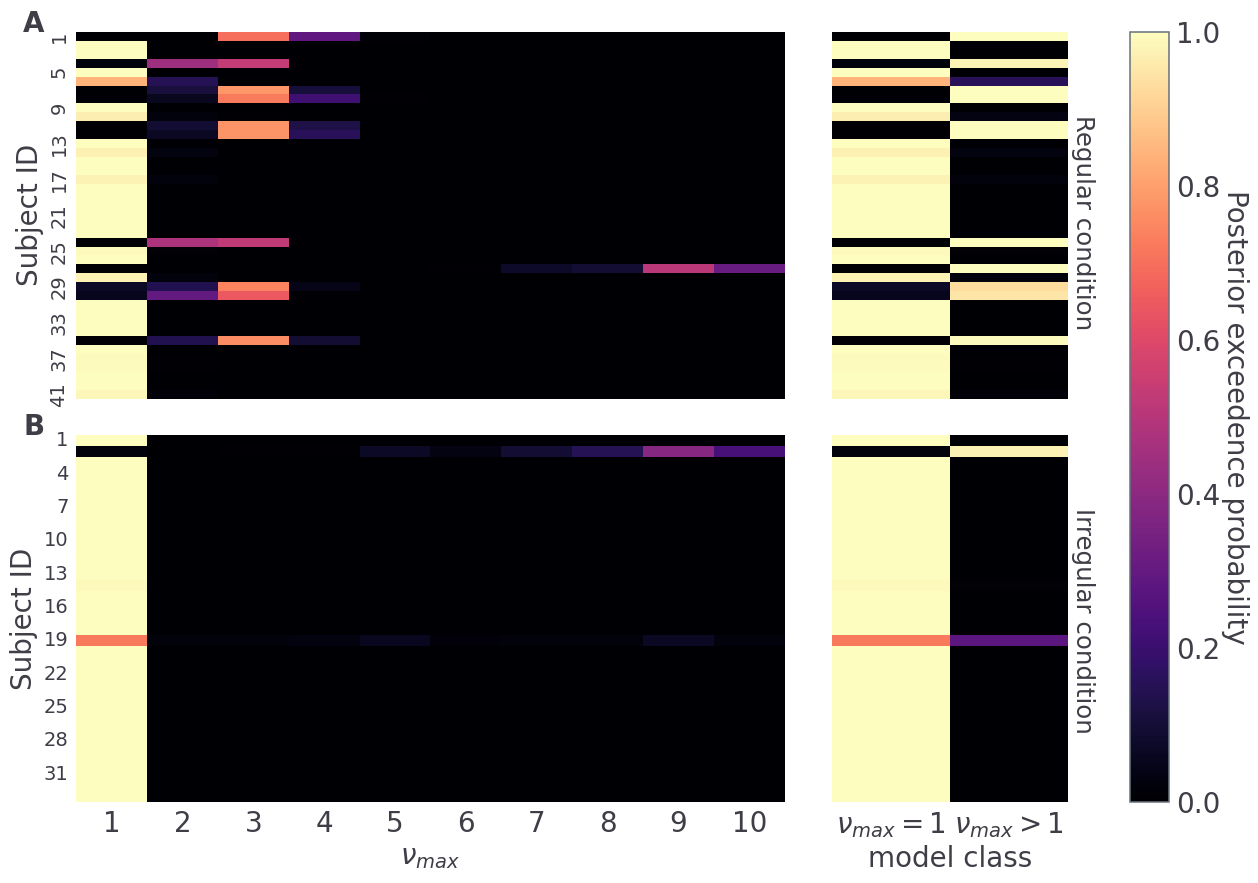

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey='row', sharex='col', gridspec_kw={
                            'wspace': 0.1,
                            'hspace': 0.1,
                            'width_ratios': [3, 1],
                         })

reg_cond = conditions.condition == 'regular'
irr_cond = conditions.condition == 'irregular'
cond = [reg_cond, irr_cond]

d = 10  # number of models
EP = np.array(samples_mixture['EP'])  # exceedance probability

xticklabels = range(1, d + 1)
for i in range(2):
    sns.heatmap(data=EP[cond[i], :], 
                ax=axes[i, 0],
                xticklabels=xticklabels,
                cbar=False, 
                vmin=0, 
                vmax=1, 
                cmap='magma')
    
for i in range(2):
    c1 = np.array(np.mean(samples_mixture['weights'].argmax(-2) > 0, 0))[cond[i]]
    data = np.stack([1 - c1, c1], -1)
    sns.heatmap(data=data, 
                ax=axes[i, 1],
                cbar=False, 
                vmin=0, 
                vmax=1, 
                cmap='magma')

axes[1, 0].set_xlabel(r'$\nu_{max}$')

axes[0, 0].set_yticklabels(range(1, ns_reg + 1, 4), fontdict={"fontsize":14})
axes[1, 0].set_yticklabels(range(1, ns_irr + 1, 3), fontdict={"fontsize":14})

axes[-1, -1].xaxis.set_ticklabels([r'$\nu_{max}=1$', r'$\nu_{max} > 1$'])
axes[-1, -1].set_xlabel('model class')

axes[0, 0].set_ylabel('Subject ID')
axes[1, 0].set_ylabel('Subject ID')

axes[0, 1].text(1.01, .2, 'Regular condition', rotation=-90, transform=axes[0, 1].transAxes);
axes[1, 1].text(1.01, .2, 'Irregular condition', rotation=-90, transform=axes[1, 1].transAxes);

for i in range(2):
    axes[i, 0].text(-.075, 1., string.ascii_uppercase[i], transform=axes[i, 0].transAxes, size=20, weight='bold')

norm = colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=axes, use_gridspec=True)
cbar.ax.set_ylabel('Posterior exceedence probability', rotation=-90, labelpad=20, fontsize=20);
fig.savefig('Fig8.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [10]:
probs = EP
n_reg = np.sum(probs[cond[0]].argmax(-1) > 0)
print('regular condition ',n_reg,  n_reg / ns_reg)

n_irr = np.sum(probs[cond[1]].argmax(-1) > 0)
print('irregular condition', n_irr, n_irr / ns_irr)
(n_reg + n_irr)/(nsub)

regular condition  11 0.2682926829268293
irregular condition 1 0.030303030303030304


0.16216216216216217

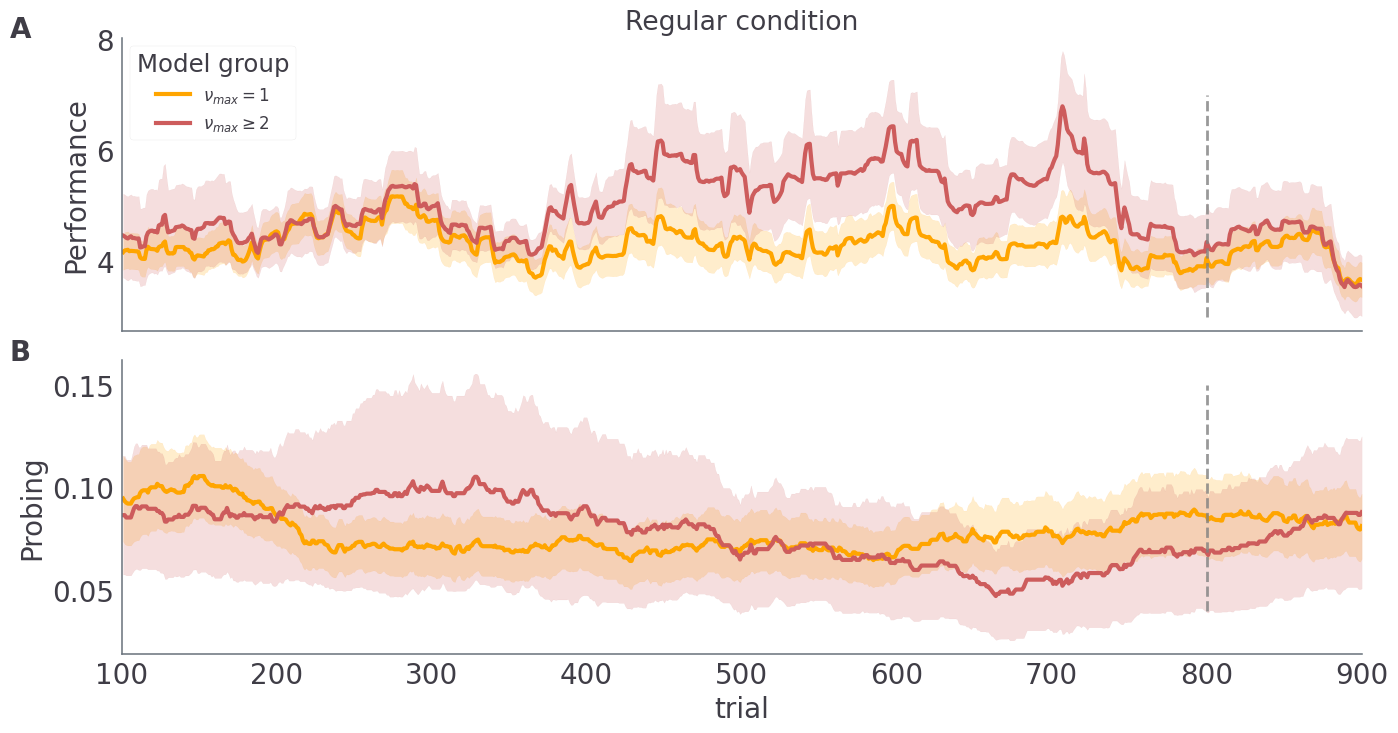

In [11]:
def get_stats(x, axis=-1, c=0.975):
    mean = x.mean(axis)
    std = x.std(axis, ddof=1)
    ci = c * std / np.sqrt(x.shape[axis])
    
    return mean, ci

ws = 201
locs1 = probs.argmax(-1) == 0
locs2 = probs.argmax(-1) >= 1

fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey='row',  
                         gridspec_kw={
                            'wspace': 0.1,
                            'hspace': 0.1
                         })

trials = np.arange(101, 901)

states = []
for c in conditions.condition:
    if c == 'regular':
        states.append(Sreg)
    else:
        states.append(Sirr)
states = np.stack(states, 0)

rolling_perf = performance(correct_choices_data, ws=ws)
rolling_odds = performance(np.nan_to_num(responses_data) == 2, ws=ws)

##############################################################################################

regs = cond[0] 
irrs = cond[1] 
rp1 = rolling_perf[regs][locs1[regs], :].T
mu, ci = get_stats(rp1)
axes[0].plot(trials, mu, color='orange', lw=3, label=r'$\nu_{max}=1$');
axes[0].fill_between(trials, mu - ci, y2=mu + ci, color='orange', alpha=.2);

rp11 = rolling_perf[regs][locs2[regs], :].T
mu, ci = get_stats(rp11)
axes[0].plot(trials, mu, color='indianred', lw=3, label=r'$\nu_{max}\geq 2$');
axes[0].fill_between(trials, mu - ci, y2=mu + ci, color='indianred', alpha=.2);
##############################################################################################

exp_reg = regs * expl_subs
rl1 = rolling_odds[exp_reg][locs1[exp_reg], :].T
mu, ci = get_stats(rl1)
axes[-1].plot(trials, mu, color='orange', lw=3, label=r'$\nu_{max}=1$');
axes[-1].fill_between(trials, mu - ci, y2=mu + ci, color='orange', alpha=.2);

rl11 = rolling_odds[exp_reg][locs2[exp_reg], :].T
mu, ci = get_stats(rl11)
axes[-1].plot(trials, mu, color='indianred', lw=3, label=r'$\nu_{max}\geq 2$');
axes[-1].fill_between(trials, mu - ci, y2=mu + ci, color='indianred', alpha=.2);
##############################################################################################

axes[0].vlines(800, 3, 7, color='gray', linestyle='--', lw=2, alpha=.8)
axes[-1].vlines(800, 0.04, 0.15, color='gray', linestyle='--', lw=2, alpha=.8)

axes[0].legend(loc=2, title='Model group', fontsize=12)

axes[0].set_ylabel('Performance');
axes[-1].set_ylabel('Probing');
axes[0].set_title('Regular condition')
axes[-1].set_xlabel('trial')
axes[-1].set_xlim([100, 900])

for i in range(2):
    axes[i].text(-.09, 1., string.ascii_uppercase[i], transform=axes[i].transAxes, size=20, weight='bold')
    
sns.despine(fig)
fig.savefig('Fig9.pdf', transparent=True, dpi=300)

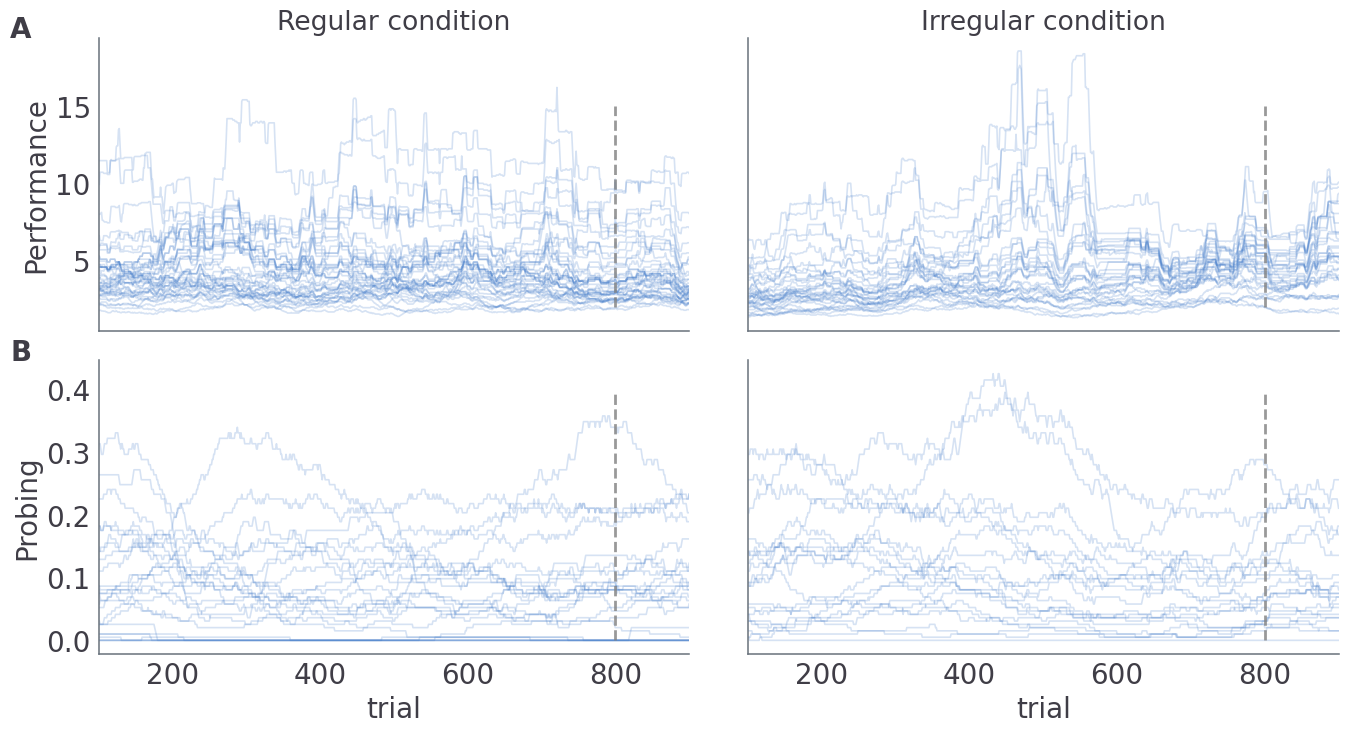

In [12]:
ws = 201
locs1 = probs.argmax(-1) == 0
locs2 = probs.argmax(-1) >= 1

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey='row',  
                         gridspec_kw={
                            'wspace': 0.1,
                            'hspace': 0.1
                         })

trials = np.arange(101, 901)

states = []
for c in conditions.condition:
    if c == 'regular':
        states.append(Sreg)
    else:
        states.append(Sirr)
states = np.stack(states, 0)

rolling_perf = performance(correct_choices_data, ws=ws)
rolling_odds = performance(np.nan_to_num(responses_data) == 2, ws=ws)

##############################################################################################

regs = cond[0] 
irrs = cond[1]

rp1 = rolling_perf[regs].T
axes[0, 0].plot(trials, rp1, color='b', alpha=0.2);
##############################################################################################

rp2 = rolling_perf[irrs].T
axes[0, 1].plot(trials, rp2, color='b', alpha=0.2);
##############################################################################################

exp_reg = regs * expl_subs
rl1 = rolling_odds[exp_reg].T
axes[-1, 0].plot(trials, rl1, color='b', alpha=0.2);
##############################################################################################

exp_irr = irrs * expl_subs
rl2 = rolling_odds[exp_irr].T
axes[-1, 1].plot(trials, rl2, color='b', alpha=0.2);
##############################################################################################

for i in range(2):
    axes[0, i].vlines(800, 2, 15, color='gray', linestyle='--', lw=2, alpha=.8)
    axes[-1, i].vlines(800, 0.0, 0.4, color='gray', linestyle='--', lw=2, alpha=.8)

axes[0, 0].set_ylabel('Performance');
axes[-1, 0].set_ylabel('Probing');
axes[0, 0].set_title('Regular condition')
axes[0, 1].set_title('Irregular condition')
axes[-1, 0].set_xlabel('trial')
axes[-1, 1].set_xlabel('trial')
axes[-1, -1].set_xlim([100, 900])

for i in range(2):
    axes[i, 0].text(-.15, 1., string.ascii_uppercase[i], transform=axes[i, 0].transAxes, size=20, weight='bold')
    
sns.despine(fig)
fig.savefig('supp_Fig9.pdf', transparent=True, dpi=300)

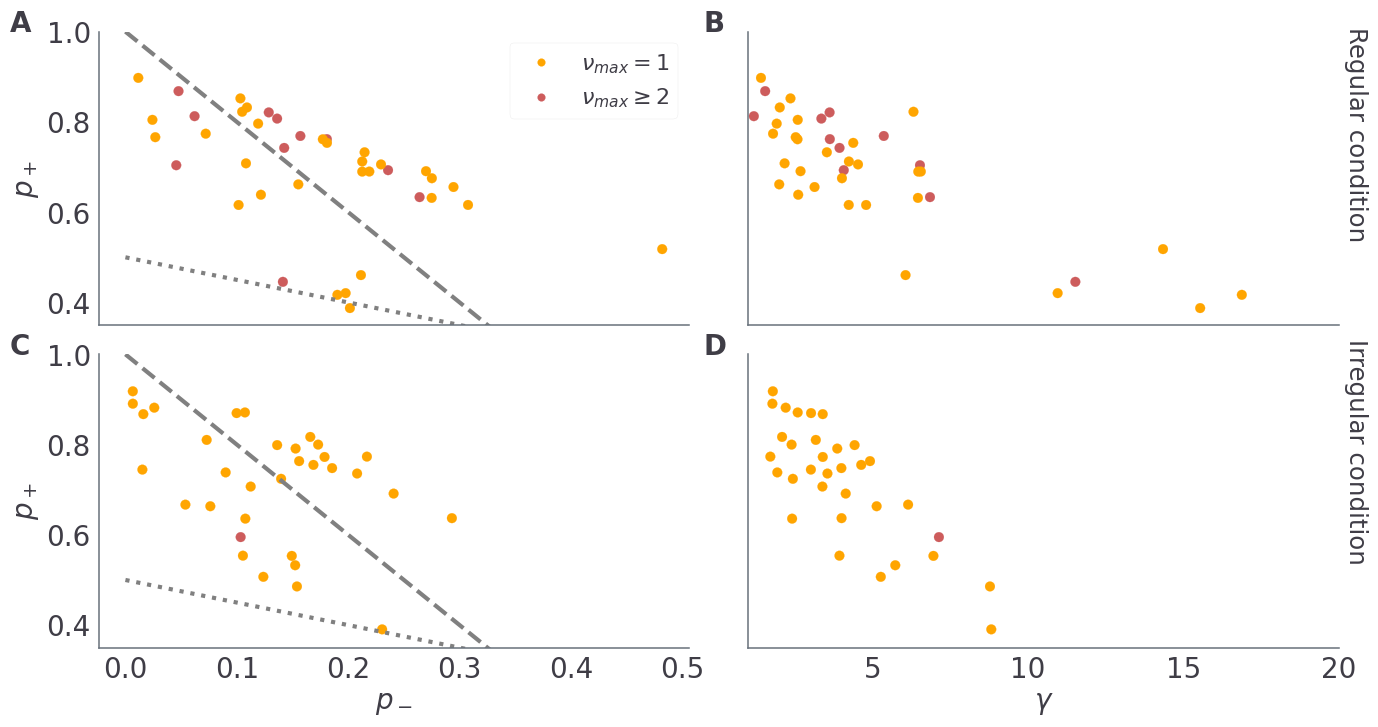

In [13]:
from matplotlib.colors import ListedColormap
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex='col', sharey='row',
                         gridspec_kw={
                            'wspace': 0.1,
                            'hspace': 0.1
                         })

cmap = ListedColormap(['orange', 'indianred'])

my_col_reg = []
for i in range(sum(regs)):
    if locs1[regs][i]:
        my_col_reg.append(0)
    elif locs2[regs][i]:
        my_col_reg.append(1)

my_col_irr = []
for j in range(sum(irrs)):
    if locs1[irrs][j]:
        my_col_irr.append(0)
    elif locs2[irrs][j]:
        my_col_irr.append(1)
    
gammas = np.median(samples_mixture['gamma'], -2)
p0 = np.median(samples_mixture['p0'], -3)

x = np.array([.0, .35]) 
sct = axes[0, 0].scatter(p0[regs, 0], p0[regs, 1], s=50, c=my_col_reg, cmap=cmap)
axes[0, 0].plot(x, 1 - 2 * x, 'gray', linestyle='--', lw=3)
axes[0, 0].plot(x, (1 - x)/2, 'gray', linestyle=':', lw=3)

axes[1, 0].scatter(p0[irrs, 0], p0[irrs, 1], s=50, c=my_col_irr, cmap=cmap)
axes[1, 0].plot(x, 1 - 2 * x, 'gray', linestyle='--', lw=3)
axes[1, 0].plot(x, (1 - x)/2, 'gray', linestyle=':', lw=3)

axes[0, 1].scatter(gammas[regs], p0[regs, 1], s=50, c=my_col_reg, cmap=cmap)
axes[1, 1].scatter(gammas[irrs], p0[irrs, 1], s=50, c=my_col_irr, cmap=cmap)

axes[0, 0].set_ylabel(r'$p_+$')
axes[1, 0].set_ylabel(r'$p_+$')
axes[1, 0].set_xlabel(r'$p_-$')
axes[1, 1].set_xlabel(r'$\gamma$')

axes[0, 0].set_ylim([0.35, 1.])
axes[1, 0].set_ylim([0.35, 1.])
axes[1, 1].set_xlim([1., 20.])

axes[0, 0].legend(handles=sct.legend_elements()[0], labels=[r'$\nu_{max}=1$', r'$\nu_{max} \geq 2$',r'$\nu_{min} \geq 1$'], loc=0)

axes[0, 0].text(-.15, 1., string.ascii_uppercase[0], transform=axes[0, 0].transAxes, size=20, weight='bold')
axes[0, 1].text(-.075, 1., string.ascii_uppercase[1], transform=axes[0, 1].transAxes, size=20, weight='bold')
axes[1, 0].text(-.15, 1., string.ascii_uppercase[2], transform=axes[1, 0].transAxes, size=20, weight='bold')
axes[1, 1].text(-.075, 1., string.ascii_uppercase[3], transform=axes[1, 1].transAxes, size=20, weight='bold')
sns.despine(fig)

axes[0, 1].text(1.01, .3, 'Regular condition', rotation=-90, transform=axes[0, 1].transAxes);
axes[1, 1].text(1.01, .3, 'Irregular condition', rotation=-90, transform=axes[1, 1].transAxes);

fig.savefig('Fig10.pdf', transparent=True, bbox_inches='tight', dpi=300)

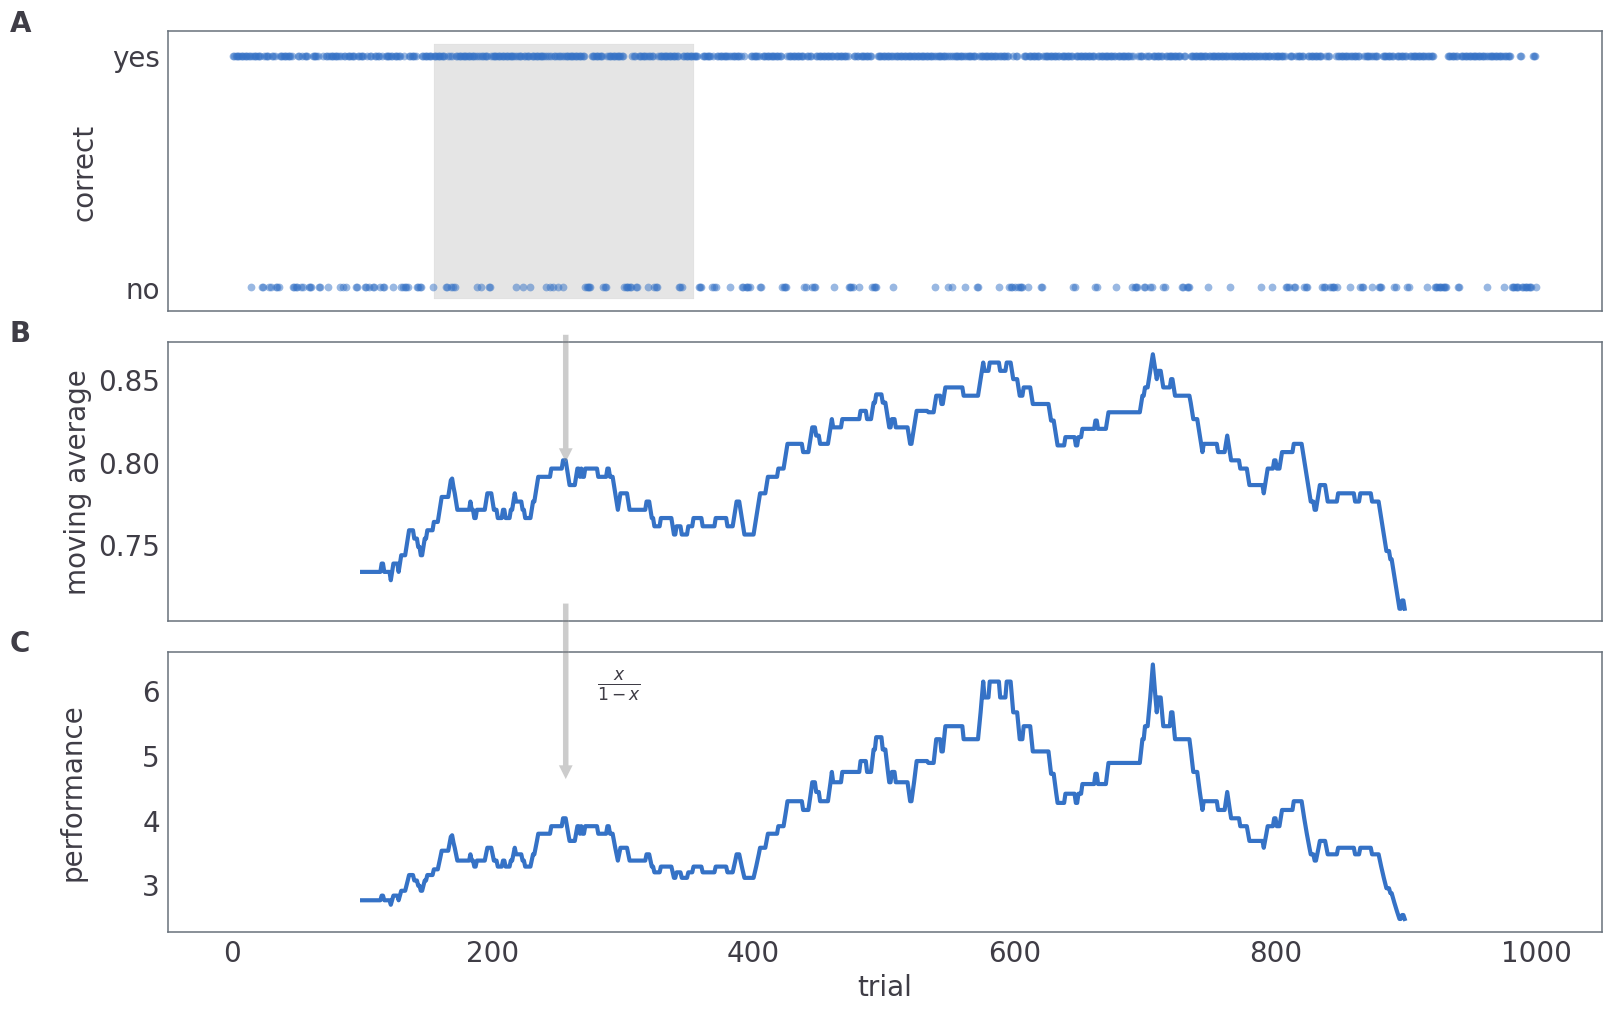

In [14]:
from matplotlib.patches import FancyArrowPatch
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True, constrained_layout=True)

axes[0].plot(range(1, 1001), correct_choices_data[:, 0], 'bo', alpha=0.5)
axes[0].fill_between(range(155, 355), 1.05, y2=-.05, color='gray', alpha=0.2)
axes[0].set_ylabel('correct', labelpad=10)
axes[0].set_yticks([0., 1.])
axes[0].set_yticklabels(['no', 'yes'])
axes[1].plot(range(100, 900), rolling_perf[0, :]/(1 + rolling_perf[0, :]), lw=3)
axes[1].set_ylabel('moving average')
axes[2].plot(range(100, 900), rolling_perf[0, :], lw=3)
axes[2].set_ylabel('performance', labelpad=40);
axes[2].set_xlabel('trial')

ax0tr = axes[0].transData # Axis 0 -> Display
ax1tr = axes[1].transData # Axis 1 -> Display
ax2tr = axes[2].transData # Axis 2 -> Display
figtr = fig.transFigure.inverted() # Display -> Figure
# 2. Transform arrow start point from axis 0 to figure coordinates
ptB = figtr.transform(ax0tr.transform((270, 0)))
# 3. Transform arrow end point from axis 1 to figure coordinates
ptE = figtr.transform(ax1tr.transform((270., .7)))
# 4. Create the patch
arrow = FancyArrowPatch(
    ptB, ptE, transform=fig.transFigure,  # Place arrow in figure coord system
    fc = "gray", arrowstyle='simple', alpha = 0.4, mutation_scale = 20.
)
# 5. Add patch to list of objects to draw onto the figure
fig.patches.append(arrow)

ptC = figtr.transform(ax1tr.transform((270., .1)))
ptD = figtr.transform(ax2tr.transform((270., 0.5)))
arrow = FancyArrowPatch(
    ptC, ptD, transform=fig.transFigure,  # Place arrow in figure coord system
    fc = "gray", arrowstyle='simple', alpha = 0.4, mutation_scale = 20.
)

axes[-1].text(280, 6., r'$\frac{x}{1-x}$')

# 5. Add patch to list of objects to draw onto the figure
fig.patches.append(arrow)
for i in range(3):
    axes[i].text(-.11, 1., string.ascii_uppercase[i], transform=axes[i].transAxes, size=20, weight='bold')
    
fig.savefig('Fig11.pdf', bbox_inches="tight", transparent=True, dpi=300)